### 作業
理解範例後請嘗試將關鍵點畫在圖像上，確保圖像及資料有正確讀取。
Hint: 可以用 [matplotlib 的 scatter](https://matplotlib.org/3.1.1/gallery/shapes_and_collections/scatter.html) 或者 [opencv 的 cv2.circle](https://docs.opencv.org/master/dc/da5/tutorial_py_drawing_functions.html)

### 範例
接下來的程式碼會示範如何讀取 kaggle facial keypoint detection 資料集

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 使用 colab 環境的同學請執行以下程式碼
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

import os
from google.colab import drive 
drive.mount('/content/gdrive', force_remount=True) # 將 google drive 掛載在 colob，
%cd 'gdrive/My Drive/cupoy_cv_part4'
#os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
#%cd 'cupoy_cv_part4' # 可以自己改路徑


`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.0
Mounted at /content/gdrive
/content/gdrive/My Drive/cupoy_cv_part4


In [3]:
%pwd

'/content/gdrive/My Drive/cupoy_cv_part4'

In [4]:
# 如果要使用 kaggle API 下載資料的話，請用以下程式碼
os.environ['KAGGLE_USERNAME'] = 'powpi2000' # 請按照 Day42 簡報內容，獲取 kaggle api 需要用到的 username
os.environ['KAGGLE_KEY'] = '1724161c7efedf1d81dc82fcfe293728' # 請按照 Day42 簡報獲取 kaggle api 需要用到的 key
!kaggle competitions download -c facial-keypoints-detection
!unzip test.zip
!unzip training.zip

IdLookupTable.csv: Skipping, found more recently modified local copy (use --force to force download)
SampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
training.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  test.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  training.zip
replace training.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


### 資料前處理
資料分為兩部分，一個是關鍵點坐標，總共 15 個關鍵點，所以坐標相關的值有 15 x 2 = 30 維；
另外還有 96 x 96 的灰階像素值。

讀取資料後，先簡單地過濾有缺失某些關鍵點坐標的資料，然後再把資料 scale 到 [-0.5, 0.5] 的範圍

In [0]:
# 讀取 csv 文件
data = pd.read_csv("training.csv")

In [6]:
# 前 5 筆資料, .T 的作用是轉置，如果不理解可以和 data.head() 的結果相比較
data.head().T

,0,1,2,3,4
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949


In [14]:
data['Image'][0]
data[data.columns[:-1]]

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2277,67.180378,35.816373,33.239956,34.921932,59.347973,37.000904,72.667896,37.097600,39.404349,36.589944,24.972418,36.348203,56.402841,31.171586,80.709708,30.595738,38.187845,30.595738,17.275454,29.534964,45.805390,60.065396,64.397610,73.248393,35.446431,74.014748,48.708626,76.760852,48.559612,77.335618
2278,65.724490,36.301020,25.377551,37.311224,58.530612,37.739796,74.448980,37.525510,33.551020,38.107143,15.979592,38.076531,56.941270,29.605102,81.314059,30.754762,35.059410,29.566780,8.578912,32.096032,53.649433,62.472789,66.928121,79.229046,28.015377,81.151722,48.771976,81.816774,49.287271,82.871156
2281,68.430866,38.651975,28.895857,37.617027,61.659350,40.100902,75.586792,40.219182,37.665118,39.087245,21.621652,39.095524,62.388142,32.089787,85.829396,38.724104,42.595762,30.541779,11.230184,34.485512,53.318891,63.289576,68.864397,77.495823,22.013981,77.368995,49.180628,79.043130,47.176739,89.544522
2282,64.152180,30.691592,27.000898,40.868082,56.505624,34.126963,73.436776,28.556335,34.746122,40.506939,16.850204,44.409861,51.463469,27.161327,77.354898,19.562755,34.135510,32.830102,9.731633,41.152347,54.075935,59.735799,73.730743,70.273886,38.777143,80.684286,58.042857,79.301429,58.611086,80.355543


用 pandas 讀取 csv 文件後可以發現前 30 個 column 是坐標值，最後一個 column 是圖片像素值的字串 (以空白鍵區隔)，接下來我們就以下的函數來做資料的讀取以及前處理，請盡量仔細理解這個函數

In [0]:
# 過濾有缺失值的 row
data = data.dropna()

# 將圖片像素值讀取為 numpy array 的形態
data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

# 單獨把圖像 array 抽取出來
imgs = np.vstack(data['Image'].values)/255
# reshape 為 96 x 96
imgs = imgs.reshape(data.shape[0], 96, 96)
# 轉換為 float
imgs = imgs.astype(np.float32)

# 提取坐標的部分
points = data[data.columns[:-1]].values

# 轉換為 float
points = points.astype(np.float32)

# normalize 坐標值到 [-0.5, 0.5]
points = points/96 - 0.5

In [9]:
print("圖像資料:", imgs.shape, "\n關鍵點資料:", points.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [0]:
sample_img = imgs[0]
sample_points = points[0]

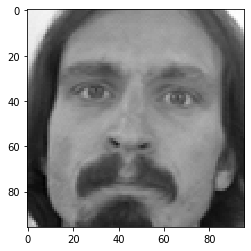

In [11]:
plt.imshow(sample_img, cmap='gray')

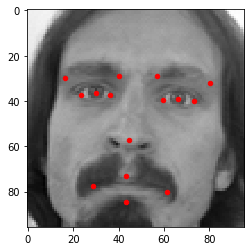

In [13]:
plt.imshow(sample_img, cmap='gray')
plt.scatter((sample_points[0:30:2]+0.5)*96, (sample_points[1:31:2]+0.5)*96, color='red',s=20)
plt.show()